In [48]:
from train_two_p import ExperimentParamsTwoP
import torch as t
from tqdm import tqdm
import random
from helpers import get_submodule_param_mask
from math import log, sqrt
from two_p_model import TwoPMLP
from two_p_dataset import make_two_p_dataset, train_test_split
from matplotlib import pyplot as plt
from datetime import datetime
from collections import defaultdict
from dataclasses import dataclass
from typing import Callable, Optional
import json
from glob import glob
from model_viz import viz_weights_modes
from movie import run_movie_cmd
import os
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from dynamics import get_magnitude_modes


@dataclass
class SGLDParams:
    gamma: float = 1
    epsilon: float = 0.001
    n_steps: int = 10000
    m: int = 512  # SGLD batch size
    restrict_to_orth_grad: bool = False
    get_updated_model_parameters: Callable = lambda model: model.parameters()  # Override to only search parameter subspace
    n_multiplier: float = 1
    movie: bool = False
    num_point_samples: Optional[int] = None
    n_magnitude_samples: Optional[int] = None
    weight_decay: float = 0
    logit_scaling: float = 1.0
    temp_multiplier: float = 1.0


def cross_entropy_loss(logits, y_s, logit_scaling=1):
    """
    logits: outputs of model
    y: target labels

    returns: mean cross entropy loss
    """
    preds = t.nn.functional.softmax(logits * logit_scaling, dim=1)
    return -1 * t.mean(t.log(preds[t.arange(len(preds)), y_s] + 1e-7))


def get_full_train_loss(model, dataset, device, logit_scaling=1):
    model = model.to(device)
    X1 = t.stack([sample[0] for sample in dataset]).to(device)
    X2 = t.stack([sample[1] for sample in dataset]).to(device)
    X3 = t.stack([sample[2] for sample in dataset]).to(device)
    X4 = t.stack([sample[3] for sample in dataset]).to(device)
    Y1 = t.stack([sample[4] for sample in dataset]).to(device)
    Y2 = t.stack([sample[5] for sample in dataset]).to(device)

    
    seeds = t.rand(Y1.size(0), device=device)
    mask = seeds < 0.5
    labels = Y1.clone()
    labels[~mask] = Y2[~mask]
    
    out = model(X1, X2, X3, X4)
    loss = cross_entropy_loss(out, labels, logit_scaling=logit_scaling)
    return loss


def mean(arr):
    return sum(arr) / len(arr)


def sgld(model, sgld_params, dataset, device):
    """
    model: MLP model
    sgld_params: SGLDParams object
    dataset: dataset to train on
    device: device to run on

    returns: updated model, lambda_hat
    """
    n = len(dataset)
    model = model.to(device)
    effective_n = n * sgld_params.n_multiplier

    inverse_temp = effective_n / log(effective_n)
    inverse_temp /= sgld_params.temp_multiplier

    init_loss = get_full_train_loss(
        model, dataset, device, logit_scaling=sgld_params.logit_scaling
    )

    idx = list(range(len(dataset)))
    optimizer = t.optim.SGD(
        sgld_params.get_updated_model_parameters(model),
        weight_decay=0,
        lr=1,
    )

    submodule_param_mask = get_submodule_param_mask(
        model, sgld_params.get_updated_model_parameters
    ).to(device)

    w_0 = (
        t.nn.utils.parameters_to_vector(model.parameters()).detach().clone().to(device)
    )

    # Compute cross entropy loss
    cross_entropy_loss_value = get_full_train_loss(
        model, dataset, device, logit_scaling=sgld_params.logit_scaling
    )

    # Compute gradients using torch.autograd.grad
    gradients = t.autograd.grad(
        cross_entropy_loss_value, model.parameters(), create_graph=True
    )
    ce_loss_grad_w0 = (
        t.nn.utils.parameters_to_vector(gradients).detach().clone().to(device)
    )
    ce_loss_grad_w0 *= submodule_param_mask
    ce_loss_grad_w0 /= ce_loss_grad_w0.norm(p=2)
    optimizer.zero_grad()

    array_loss = []
    array_weight_norm = []
    magnitude_modes = []

    frame_every = sgld_params.n_steps // 50
    sample_every = None
    if sgld_params.num_point_samples is not None:
        sample_every = sgld_params.n_steps // sgld_params.num_point_samples
        # make directory for point samples
        os.makedirs("point_samples", exist_ok=True)
        # empty directory
        files = glob("point_samples/*.json")
        for f in files:
            os.remove(f)
    mag_every = None
    if sgld_params.n_magnitude_samples is not None:
        mag_every = sgld_params.n_steps // sgld_params.n_magnitude_samples
    step = 0
    for sgld_step in tqdm(range(sgld_params.n_steps)):
        batch_idx = random.choices(idx, k=sgld_params.m)
        X1 = t.stack([dataset[b][0] for b in batch_idx]).to(device)
        X2 = t.stack([dataset[b][1] for b in batch_idx]).to(device)
        X3 = t.stack([dataset[b][2] for b in batch_idx]).to(device)
        X4 = t.stack([dataset[b][3] for b in batch_idx]).to(device)
        Y1 = t.stack([dataset[b][4] for b in batch_idx]).to(device)
        Y2 = t.stack([dataset[b][5] for b in batch_idx]).to(device)
        
        seeds = t.rand(Y1.size(0), device=device)
        mask = seeds < 0.5
        labels = Y1.clone()
        labels[~mask] = Y2[~mask]
    
        optimizer.zero_grad()
        out = model(X1, X2, X3, X4)
        cross_entropy_loss_value = cross_entropy_loss(
            out, labels, logit_scaling=sgld_params.logit_scaling
        )
        
        array_loss.append(cross_entropy_loss_value.item())
        w = t.nn.utils.parameters_to_vector(model.parameters())
        array_weight_norm.append((w * submodule_param_mask).norm(p=2).item())
        elasticity_loss_term = (sgld_params.gamma / 2) * t.sum(((w_0 - w) ** 2))
        weight_size_term = t.sum(w**2) * (sgld_params.weight_decay / 2)
        log_likelihood_loss_term = (
            cross_entropy_loss_value + weight_size_term
        ) * inverse_temp
        full_loss = (sgld_params.epsilon / 2) * (
            elasticity_loss_term + log_likelihood_loss_term
        )
        full_loss.backward()
        optimizer.step()
        eta = (
            t.randn_like(w, device=device)
            * sqrt(sgld_params.epsilon)
            * submodule_param_mask
        )
        with t.no_grad():
            new_params = t.nn.utils.parameters_to_vector(model.parameters()) + eta
            if sgld_params.restrict_to_orth_grad:
                diff = new_params - w_0
                proj_diff = diff - t.dot(diff, ce_loss_grad_w0) * ce_loss_grad_w0
                new_params = w_0 + proj_diff
            t.nn.utils.vector_to_parameters(new_params, model.parameters())

        if sgld_step % frame_every == 0 and sgld_params.movie:
            viz_weights_modes(
                model.embedding.weight.detach().cpu(),
                out.shape[-1],
                f"frames/embeddings_movie_{step:06}.png",
            )
            step += 1

        if sample_every is not None:
            if sgld_step % sample_every == 0:
                with t.no_grad():
                    full_loss_value = get_full_train_loss(
                        model, dataset, device, logit_scaling=sgld_params.logit_scaling
                    ).item()
                    data = {
                        "full_loss": float(full_loss_value),
                        "new_params": list(
                            [float(x) for x in new_params.cpu().numpy().flatten()]
                        ),
                    }
                    with open(
                        f"point_samples/point_sample_{sgld_step:06}.json", "w"
                    ) as f:
                        json.dump(data, f)
        if mag_every is not None:
            if sgld_step % mag_every == 0:
                with t.no_grad():
                    p = model.embedding.weight.shape[0]
                    modes = get_magnitude_modes(
                        model.embedding.weight.detach().cpu(), p
                    )
                    modes = modes.tolist()
                    modes = modes[1 : p // 2 + 1]
                    magnitude_modes.append(modes)

    lambda_hat = (mean(array_loss[len(array_loss) // 4 :]) - init_loss) * inverse_temp

    print(f"lambda_hat: {lambda_hat}")
    print(f"init_loss: {init_loss}")
    print(f"sgld_params: {sgld_params}")
    print(f"array_loss: {array_loss[::len(array_loss)//20]}")
    print(f"array_weight_norm: {array_weight_norm[::len(array_weight_norm)//20]}")
    if sgld_params.movie:
        run_movie_cmd("sgld")
    if sgld_params.num_point_samples is not None:
        point_sample_pca(colormapping_loss=True)
    if len(magnitude_modes) > 0:
        # Get indices of largest 2 modes at init
        init_modes = magnitude_modes[0]
        init_modes = sorted(
            range(len(init_modes)), key=lambda i: init_modes[i], reverse=True
        )
        mode_1 = init_modes[0]
        mode_2 = init_modes[1]
        # Get the values of mode_1 and mode_2 at each step
        mode_1_values = [m[mode_1] for m in magnitude_modes]
        mode_2_values = [m[mode_2] for m in magnitude_modes]
        # Plot
        plt.clf()
        fig, ax = plt.subplots()
        cmap = plt.cm.get_cmap("rainbow")
        norm = plt.Normalize(vmin=0, vmax=len(mode_1_values))
        colors = [cmap(norm(i)) for i in range(len(mode_1_values))]
        ax.scatter(mode_1_values, mode_2_values, marker="o", s=10, c=colors)
        ax.set_xlabel(f"Mode {mode_1+1}")
        ax.set_ylabel(f"Mode {mode_2+1}")
        fig.savefig(
            f'plots/magnitude_modes_SGLD_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
        )
        plt.clf()
        fig, ax = plt.subplots()
        for i, m in enumerate(magnitude_modes):
            ax.plot(
                m[: p // 2 + 1],
                label=f"Step {mag_every*i}",
                marker="o",
                c=colors[i],
                markersize=6,
            )
        ax.set_xlabel("Mode")
        ax.set_ylabel("Magnitude")
        ax.legend()
        # title
        plt.title("Fourier mode magnitude vs. SGLD sampling checkpoint")
        fig.savefig(
            f'plots/magnitude_modes_SGLD_all_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
        )
    return model, lambda_hat


def point_sample_pca(colormapping_loss=True):
    # get point samples from /point_samples and plot pca in weight space with color corresponding to full loss (use rainbow colormap)
    files = glob("point_samples/*.json")
    # sort filenames by sgld step
    files = sorted(files, key=lambda x: int(x.split("_")[-1].split(".")[0]))
    points = []
    losses = []
    for f in files:
        with open(f, "r") as f:
            data = json.load(f)
            points.append(data["new_params"])
            losses.append(data["full_loss"])
    points = t.tensor(points)
    losses = t.tensor(losses)
    # normalize points
    points = (points - points.mean(dim=0)) / points.std(dim=0)
    # fillnan with 0
    points[points != points] = 0

    print("points", points.shape)
    print("losses", losses.shape)
    pca = PCA(n_components=2)
    pca.fit(points)
    points_pca = pca.transform(points)
    print("points_pca", points_pca.shape)
    print("explained variance", pca.explained_variance_ratio_)
    print("singular values", pca.singular_values_)
    print("components", pca.components_)
    print("mean", pca.mean_)
    print("noise variance", pca.noise_variance_)
    print("losses", losses)

    # Plot 200 equally spaced points
    points_pca = points_pca[:: len(points_pca) // 200]
    losses = losses[:: len(losses) // 200]

    # Plot PCA
    plt.clf()
    fig, ax = plt.subplots()

    # Round losses to 2 decimal places
    losses = [float(l) for l in losses]

    # map color to loss
    if colormapping_loss:
        cmap = plt.cm.get_cmap("rainbow")
        norm = plt.Normalize(vmin=min(losses), vmax=max(losses))
        colors = [cmap(norm(l)) for l in losses]
    else:
        cmap = plt.cm.get_cmap("rainbow")
        norm = plt.Normalize(vmin=0, vmax=len(losses))
        colors = [cmap(norm(i)) for i in range(len(losses))]

    # Plot points with small marker size
    ax.scatter(points_pca[:, 0], points_pca[:, 1], c=colors, s=6)

    # Label points with loss values
    # for i, txt in enumerate([f"{i}, {round(l, 2)}" for i, l in enumerate(losses)]):
    #     ax.annotate(txt, (points_pca[i][0], points_pca[i][1]), fontsize=7)

    # Set x and y labels
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    fig.savefig(
        f'plots/point_samples_pca_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
    )


def hyperparameter_search(
    params_modular_addition_file,
    params_random_file,
    n_steps,
    m,
    epsilon_range,
    gamma_range,
):
    sgld_params = SGLDParams()
    sgld_params.m = m
    params_modular_addition = ExperimentParams.load_from_file(
        params_modular_addition_file
    )
    params_random = ExperimentParams.load_from_file(params_random_file)
    random_dataset = make_random_dataset(params_random.p, params_random.random_seed)
    modular_addition_dataset = make_dataset(params_modular_addition.p)
    random_dataset, _ = train_test_split(
        random_dataset, params_random.train_frac, params_random.random_seed
    )
    modular_addition_dataset, _ = train_test_split(
        modular_addition_dataset,
        params_modular_addition.train_frac,
        params_modular_addition.random_seed,
    )
    results_random = defaultdict(list)
    results_modular_addition = defaultdict(list)
    for epsilon in epsilon_range:
        actual_n_steps = int(n_steps / epsilon)
        sgld_params.epsilon = epsilon
        sgld_params.n_steps = actual_n_steps
        for gamma in gamma_range:
            mlp_modular_addition = MLP(params_modular_addition)
            mlp_random = MLP(params_random)
            sgld_params.gamma = gamma
            mlp_modular_addition.load_state_dict(
                t.load(f"models/model_{params_modular_addition.get_suffix()}.pt")
            )
            mlp_random.load_state_dict(
                t.load(f"models/model_{params_random.get_suffix()}.pt")
            )
            _, lambda_hat_modular_addition = sgld(
                mlp_modular_addition,
                sgld_params,
                modular_addition_dataset,
                params_modular_addition.device,
            )
            _, lambda_hat_random = sgld(
                mlp_random,
                sgld_params,
                random_dataset,
                params_random.device,
            )
            results_modular_addition[epsilon].append(lambda_hat_modular_addition)
            results_random[epsilon].append(lambda_hat_random)
    # plot results
    for epsilon in epsilon_range:
        plt.clf()
        plt.figure()
        plt.plot(
            gamma_range, results_modular_addition[epsilon], label="modular addition"
        )
        plt.plot(gamma_range, results_random[epsilon], label="random")
        plt.title(
            f"$\lambda$ vs $\gamma$ ($\epsilon$={epsilon}, n_steps={n_steps}, m={m})"
        )
        plt.xlabel("$\gamma$")
        plt.ylabel("$\hat{\lambda}$")
        plt.legend()
        plt.savefig(
            f'plots/lambda_vs_gamma_epsilon_{epsilon}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
        )
        plt.close()
    for idx, gamma in enumerate(gamma_range):
        plt.clf()
        plt.figure()
        results_per_epsilon_modular_addition = [
            results_modular_addition[epsilon][idx] for epsilon in epsilon_range
        ]
        results_per_epsilon_random = [
            results_random[epsilon][idx] for epsilon in epsilon_range
        ]
        plt.plot(
            epsilon_range,
            results_per_epsilon_modular_addition,
            label="modular addition",
        )
        plt.plot(epsilon_range, results_per_epsilon_random, label="random")
        plt.title(
            f"$\lambda$ vs $\epsilon$ ($\gamma$={gamma}, n_steps={n_steps}, m={m})"
        )
        plt.xlabel("$\epsilon$")
        plt.ylabel("$\hat{\lambda}$")
        plt.legend()
        plt.savefig(
            f'plots/lambda_vs_epsilon_gamma_{gamma}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
        )
        plt.close()


def n_mult_search(
    params_modular_addition_file,
    params_random_file,
    sgld_params,
    n_multiplier_range,
):
    params_modular_addition = ExperimentParams.load_from_file(
        params_modular_addition_file
    )
    params_random = ExperimentParams.load_from_file(params_random_file)
    random_dataset = make_random_dataset(params_random.p, params_random.random_seed)
    modular_addition_dataset = make_dataset(params_modular_addition.p)
    random_dataset, _ = train_test_split(
        random_dataset, params_random.train_frac, params_random.random_seed
    )
    modular_addition_dataset, _ = train_test_split(
        modular_addition_dataset,
        params_modular_addition.train_frac,
        params_modular_addition.random_seed,
    )
    results_random = []
    results_modular_addition = []
    for n_mult in n_multiplier_range:
        mlp_modular_addition = TwoPMLP(params_modular_addition)
        mlp_random = TwoPMLP(params_random)
        sgld_params.n_multiplier = n_mult
        mlp_modular_addition.load_state_dict(
            t.load(f"models/model_{params_modular_addition.get_suffix()}.pt")
        )
        mlp_random.load_state_dict(
            t.load(f"models/model_{params_random.get_suffix()}.pt")
        )
        _, lambda_hat_modular_addition = sgld(
            mlp_modular_addition,
            sgld_params,
            modular_addition_dataset,
            params_modular_addition.device,
        )
        _, lambda_hat_random = sgld(
            mlp_random,
            sgld_params,
            random_dataset,
            params_random.device,
        )
        results_modular_addition.append(lambda_hat_modular_addition)
        results_random.append(lambda_hat_random)
    plt.clf()
    plt.figure()
    plt.plot(
        n_multiplier_range,
        results_modular_addition,
        label="modular addition",
        marker="o",
        linestyle="--",
    )
    plt.plot(
        n_multiplier_range, results_random, label="random", marker="o", linestyle="--"
    )
    plt.title(f"$\hat\lambda$ vs n_mult")
    plt.xlabel("n_mult")
    plt.ylabel("$\hat{\lambda}$")
    plt.legend()
    plt.savefig(
        f'plots/lambda_vs_n_mult_{n_mult}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
    )
    plt.close()


def get_lambda(params, sgld_params, checkpoint_no=None):
    model = TwoPMLP(params)
    if checkpoint_no is None:
        model.load_state_dict(t.load(f"models/model_{params.get_suffix()}.pt"))
    else:
        model.load_state_dict(
            t.load(
                f"models/checkpoints/{params.get_suffix(checkpoint_no=checkpoint_no)}.pt"
            )
        )

    dataset = make_two_p_dataset(params)
    train_data, test_data = train_test_split(
        dataset, params
    )
    test_loss = get_full_train_loss(model, test_data, params.device)
    train_loss = get_full_train_loss(model, train_data, params.device)
    _, lambda_hat = sgld(model, sgld_params, train_data, params.device)
    lambda_hat, test_loss, train_loss = lambda_hat.cpu().item(), test_loss.cpu().item(), train_loss.cpu().item()
    return lambda_hat, test_loss, train_loss


def get_lambda_per_quantity(param_files, sgld_params, resample=True):
    lambda_values = []
    test_losses = []
    train_losses = []
    for param_file in param_files:
        params = ExperimentParams.load_from_file(param_file)
        if not resample and params.lambda_hat is not None:
            lambda_values.append(params.lambda_hat)
            continue
        lambda_hat, test_loss, train_loss = get_lambda(params, sgld_params)
        lambda_values.append(lambda_hat)
        test_losses.append(test_loss)
        train_losses.append(train_loss)
        param_dict = params.get_dict()
        param_dict["lambda_hat"] = lambda_hat
        param_dict["test_loss"] = test_loss
        param_dict["train_loss"] = train_loss
        with open(param_file, "w") as f:
            json.dump(param_dict, f)
    return lambda_values, test_losses, train_losses


def plot_lambda_test_train_loss(
    ax1, x_axis, x_label, lambda_values, test_losses, train_losses
):
    # Plot lambda values on the left y-axis
    ax1.plot(x_axis, lambda_values, marker="o", label="$\hat{\lambda}$", color="g")
    # ax1.plot(x_axis, [8 * x for x in x_axis], label="y=8x", linestyle="--")
    ax1.set_xlabel(x_label)
    ax1.set_ylabel("$\hat{\lambda}$")
    ax1.tick_params("y", colors="g")
    ax1.legend(loc="upper left")

    # Create a second y-axis for the losses
    ax2 = ax1.twinx()
    ax2.plot(
        x_axis, train_losses, marker="o", color="b", label="train loss", linestyle="--"
    )
    ax2.plot(
        x_axis, test_losses, marker="o", color="r", label="test loss", linestyle="--"
    )
    ax2.set_ylabel("Loss", color="b")
    ax2.tick_params("y", colors="b")
    ax2.legend(loc="lower right")


def plot_lambda_per_quantity(param_files, quantity_values, quantity_name, sgld_params):
    lambda_values, test_losses, train_losses = get_lambda_per_quantity(
        param_files, sgld_params
    )

    # Clear previous plots
    plt.clf()
    fig, ax1 = plt.subplots()

    plot_lambda_test_train_loss(
        ax1, quantity_values, quantity_name, lambda_values, test_losses, train_losses
    )

    # Set title
    ax1.set_title(f"$\lambda$ vs {quantity_name}")

    # Save the figure
    fig.savefig(
        f'plots/lambda_vs_{quantity_name.replace(" ", "_")}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
    )

    plt.close()


def plot_lambda_per_checkpoint(param_file, sgld_params, checkpoints=None):
    lambda_values = []
    train_losses = []
    test_losses = []
    params = ExperimentParams.load_from_file(param_file)
    check_list = list(range(params.n_save_model_checkpoints))
    if checkpoints is not None:
        check_list = checkpoints
    for i in check_list:
        lambda_hat, test_loss, train_loss = get_lambda(
            params, sgld_params, checkpoint_no=i
        )
        lambda_values.append(lambda_hat)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    # Clear previous plots
    plt.clf()
    fig, ax1 = plt.subplots()

    # Plot lambda values on the left y-axis
    plot_lambda_test_train_loss(
        ax1, check_list, "Checkpoint", lambda_values, test_losses, train_losses
    )

    # Set title
    title = "$\lambda$ vs checkpoint"
    if sgld_params.restrict_to_orth_grad:
        title += " (restrict orth dir)"
    if sgld_params.n_multiplier != 1:
        title += f" (n*={sgld_params.n_multiplier})"
    ax1.set_title(title)

    # Save the figure
    fig.savefig(
        f'plots/lambda_vs_checkpoint_{datetime.now().strftime("%Y%m%d_%H%M%S")}_restrictorth{sgld_params.restrict_to_orth_grad}.png'
    )

    plt.close()


def plot_lambda_per_checkpoint_multi_run(sgld_params, sweep_dir):
    files = glob(f"{sweep_dir}/*.json")

    results = defaultdict(dict)
    for f in files:
        exp_params = ExperimentParams.load_from_file(f)
        run_id = exp_params.run_id
        n_checkpoints = exp_params.n_save_model_checkpoints
        check_list = list(range(n_checkpoints))
        for c in check_list:
            lambda_hat, test_loss, train_loss = get_lambda(
                exp_params, sgld_params, checkpoint_no=c
            )
            results[run_id][c] = (lambda_hat, test_loss, train_loss)

    # Clear previous plots
    plt.clf()
    fig, ax1 = plt.subplots()
    # Plot mean lambda, test loss, and train loss per checkpoint (mean over runs)
    run_ids = sorted(list(results.keys()))
    lambda_values = []
    test_losses = []
    train_losses = []
    for c in check_list:
        lambda_values.append(t.mean(t.tensor([run[c][0] for run in results.values()])))
        test_losses.append(t.mean(t.tensor([run[c][1] for run in results.values()])))
        train_losses.append(t.mean(t.tensor([run[c][2] for run in results.values()])))
    plot_lambda_test_train_loss(
        ax1, check_list, "Checkpoint", lambda_values, test_losses, train_losses
    )

    # Set title
    title = "$\lambda$ vs checkpoint"
    if sgld_params.restrict_to_orth_grad:
        title += " (restrict orth dir)"
    if sgld_params.n_multiplier != 1:
        title += f" (n*={sgld_params.n_multiplier})"
    ax1.set_title(title)

    # Save the figure
    fig.savefig(
        f'plots/lambda_vs_checkpoint_{datetime.now().strftime("%Y%m%d_%H%M%S")}_restrictorth{sgld_params.restrict_to_orth_grad}_meanover_{len(run_ids)}.png'
    )


def plot_lambda_per_p(sgld_params, p_sweep_dir, resample=False, append_to_title=""):
    files = glob(f"{p_sweep_dir}/*.json")
    results = defaultdict(dict)
    for f in files:
        exp_params = ExperimentParams.load_from_file(f)
        p = exp_params.p
        run_id = exp_params.run_id
        if not resample and all(
            [
                exp_params.lambda_hat is not None,
                exp_params.test_loss is not None,
                exp_params.train_loss is not None,
            ]
        ):
            results[p][run_id] = (
                exp_params.lambda_hat,
                exp_params.test_loss,
                exp_params.train_loss,
            )
            continue
        lambda_hat, test_loss, train_loss = get_lambda(exp_params, sgld_params)
        results[p][run_id] = (lambda_hat, test_loss, train_loss)
        exp_params.lambda_hat = lambda_hat
        exp_params.test_loss = test_loss
        exp_params.train_loss = train_loss
        exp_params.save_to_file(f)
    print("Extracted results", results)

    # Plot average lambda, test loss, and train loss per p (mean over runs)
    fig, ax1 = plt.subplots()
    p_values = sorted(list(results.keys()))
    lambda_values = []
    test_losses = []
    train_losses = []
    for p in p_values:
        lambda_values.append(t.mean(t.tensor([run[0] for run in results[p].values()])))
        test_losses.append(t.mean(t.tensor([run[1] for run in results[p].values()])))
        train_losses.append(t.mean(t.tensor([run[2] for run in results[p].values()])))
    plot_lambda_test_train_loss(
        ax1, p_values, "p", lambda_values, test_losses, train_losses
    )
    ax1.set_title("$\lambda$ vs p")
    fig.savefig(
        f'plots/lambda_vs_p_{datetime.now().strftime("%Y%m%d_%H%M%S")}_{append_to_title}.png'
    )
    print("Saved plot 1")

    # Plot lambda (each run is a different color)
    run_ids = sorted(list(results[p_values[0]].keys()))
    plt.clf()
    fig, ax1 = plt.subplots()
    for run_id in run_ids:
        lambda_values = []
        for p in p_values:
            lambda_values.append(results[p][run_id][0])
        ax1.plot(p_values, lambda_values, marker="o", label=f"Run {run_id}")
    ax1.set_xlabel("p")
    ax1.set_ylabel("$\hat{\lambda}$")
    ax1.legend(loc="upper left")
    ax1.set_title("$\lambda$ vs p")
    fig.savefig(
        f'plots/lambda_vs_p_runs_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
    )
    print("Saved plot 2")


def plot_lambda_per_p_different_exps(exp_dirs, exp_names, sgld_params, resample=False):
    """
    exp_dirs: list of directories containing experiment params json files corresponding to different p value sweeps
    exp_names: name of experiment being run for that p sweep
    sgld_params: List of SGLDParams objects, or single settings - SGLD settings to use for each exp_dir
    resample: whether to resample if lambda already saved
    """
    # If sgld_params is not a list, make it a list
    if not isinstance(sgld_params, list):
        sgld_params = [sgld_params] * len(exp_dirs)
    results = defaultdict(lambda: defaultdict(list))
    for i, d in enumerate(exp_dirs):
        files = glob(f"{d}/*.json")
        for f in files:
            exp_params = ExperimentParams.load_from_file(f)
            p = exp_params.p
            if not resample and exp_params.lambda_hat is not None:
                results[exp_names[i]][p].append(exp_params.lambda_hat)
            else:
                lambda_hat, _, _ = get_lambda(exp_params, sgld_params[i])
                results[exp_names[i]][p].append(lambda_hat)
                exp_params.lambda_hat = lambda_hat
                exp_params.save_to_file(f)

    # lambda per p for each exp on same plot
    plt.clf()
    fig = plt.figure(figsize=(6, 6))
    for n in exp_names:
        p_values = sorted(list(results[n].keys()))
        lambda_values = []
        for p in p_values:
            l = sum(results[n][p]) / len(results[n][p])
            lambda_values.append(l)
        plt.plot(p_values, lambda_values, marker="o", label=n, linestyle="--")
    plt.xlabel("p")
    plt.ylabel("$\hat{\lambda}$")
    plt.legend()
    plt.title("$\lambda$ vs p")
    fig.savefig(f'plots/lambda_vs_p_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png')


def plot_lambda_per_frac(sgld_params, frac_sweep_dir, resample=False):
    files = glob(f"{frac_sweep_dir}/*.json")
    results = defaultdict(dict)
    for f in files:
        exp_params = ExperimentParams.load_from_file(f)
        frac = exp_params.train_frac
        run_id = exp_params.run_id
        if not resample and all(
            [
                exp_params.lambda_hat is not None,
                exp_params.test_loss is not None,
                exp_params.train_loss is not None,
            ]
        ):
            results[frac][run_id] = (
                exp_params.lambda_hat,
                exp_params.test_loss,
                exp_params.train_loss,
            )
            continue
        lambda_hat, test_loss, train_loss = get_lambda(exp_params, sgld_params)
        results[frac][run_id] = (lambda_hat, test_loss, train_loss)
        exp_params.lambda_hat = lambda_hat
        exp_params.test_loss = test_loss
        exp_params.train_loss = train_loss
        exp_params.save_to_file(f)
    print("Extracted results", results)

    # Plot average lambda, test loss, and train loss per p (mean over runs)
    fig, ax1 = plt.subplots()
    frac_values = sorted(list(results.keys()))
    lambda_values = []
    test_losses = []
    train_losses = []
    for frac in frac_values:
        lambda_values.append(
            t.mean(t.tensor([run[0] for run in results[frac].values()]))
        )
        test_losses.append(t.mean(t.tensor([run[1] for run in results[frac].values()])))
        train_losses.append(
            t.mean(t.tensor([run[2] for run in results[frac].values()]))
        )
    plot_lambda_test_train_loss(
        ax1, frac_values, "train_frac", lambda_values, test_losses, train_losses
    )
    ax1.set_title("$\lambda$ vs train_frac")
    fig.savefig(f'plots/lambda_vs_frac_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png')


def slope_vs_n_mult(sgld_params, exp_dir, n_mults):
    files = glob(f"{exp_dir}/*.json")
    slopes = []
    for n_mult in n_mults:
        sgld_params.n_multiplier = n_mult
        results = defaultdict(dict)
        for f in files:
            exp_params = ExperimentParams.load_from_file(f)
            p = exp_params.p
            run_id = exp_params.run_id
            lambda_hat, test_loss, train_loss = get_lambda(exp_params, sgld_params)
            results[p][run_id] = (
                lambda_hat,
                test_loss,
                train_loss,
            )
            exp_params.lambda_hat = lambda_hat
            exp_params.test_loss = test_loss
            exp_params.train_loss = train_loss
            exp_params.save_to_file(f)

        with open(f"results/results_n_mult_{n_mult}.json", "w") as f:
            json.dump(dict(results), f)

        avg_over_runs = defaultdict(list)
        for p in results.keys():
            for run_id in results[p].keys():
                avg_over_runs[p].append(results[p][run_id][0])
        for p in avg_over_runs.keys():
            avg_over_runs[p] = sum(avg_over_runs[p]) / len(avg_over_runs[p])
        p1 = list(avg_over_runs.keys())[0]
        p2 = list(avg_over_runs.keys())[-1]
        avg_lambda_p1 = avg_over_runs[p1]
        avg_lambda_p2 = avg_over_runs[p2]
        slope = abs((avg_lambda_p2 - avg_lambda_p1) / (p2 - p1))
        slopes.append(slope)
    plt.clf()
    plt.figure()
    plt.plot(n_mults, slopes, marker="o")
    plt.title("Slope of $\lambda$ vs p")
    plt.xlabel("n_multiplier")
    plt.ylabel("Slope")
    # log scale on x axis
    plt.xscale("log")
    plt.savefig(
        f'plots/slope_lambda_vs_p_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
    )
    plt.close()


def grok_exp():
    temp_multipliers = [0.1, 0.3, 1, 3]
    files = {
        2: list(glob("exp_params/QUADRATIC/*2grok.json")),
        3: list(glob("exp_params/QUADRATIC/*3grok.json")),
        4: list(glob("exp_params/QUADRATIC/*4grok.json")),
        # 5: list(glob("exp_params/rerun_exps/*5grok.json")),
    }
    full_results = []
    plt.clf()
    for tm in temp_multipliers:
        sgld_params = SGLDParams(
            gamma=5,
            epsilon=0.0001,
            n_steps=5000,
            m=200,
            temp_multiplier=tm,
            get_updated_model_parameters=lambda m: m.embedding.parameters(),
        )
        results = []
        for n_groks, filenames in files.items():
            lambdas = []
            for f in filenames:
                exp_params = ExperimentParams.load_from_file(f)
                lambda_hat, _, _ = get_lambda(exp_params, sgld_params)
                lambdas.append(lambda_hat)
            mean_lambda = sum(lambdas) / len(lambdas)
            results.append(mean_lambda)
        full_results.append(results)
        plt.plot(
            list(files.keys()),
            results,
            marker="o",
            label=f"temp_multiplier={tm}",
            linestyle="--",
        )
        print(f"temp_multiplier={tm}, results={results}")
    print(f"full_results={full_results}")
    plt.xlabel("# circuits")
    plt.ylabel("$\hat{\lambda}$")
    plt.xticks(list(files.keys()))
    plt.legend()
    plt.title("$\hat{\lambda}$ vs # circuits at different temperatures")
    plt.savefig(
        f'plots/lambda_vs_n_groks_{datetime.now().strftime("%Y%m%d_%H%M%S")}.png'
    )


if __name__ == "__main__":
    import csv
    import plotly.express as px
    import pandas as pd
    import sympy

    sgld_params = SGLDParams(
        gamma=5,
        epsilon=0.0001,
        n_steps=50,
        m=64,
        restrict_to_orth_grad=True,
        weight_decay=0.0
    )

    primes_under_100 = sympy.primerange(1, 100)
    llc_results = []
    # print(list(primes_under_100))

    for p1 in sympy.primerange(1, 100):
        for p2 in sympy.primerange(1, 100):
            print(p1, p2)
            param_file = f"exp_params/two_p_modadd/p1={p1}_p2={p2}.json"
            try:
                params = ExperimentParamsTwoP.load_from_file(param_file)
                check_list = list(range(params.n_save_model_checkpoints))
                lambda_hat, test_loss, train_loss = get_lambda(params, sgld_params, check_list[-1])
                llc_results.append({'p1': p1, 'p2': p2, 'LLC': lambda_hat})
            except FileNotFoundError:
                print(f"File not found: {param_file}")
                continue

    with open('llc_results.csv', mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['p1', 'p2', 'LLC'])
        writer.writeheader()
        writer.writerows(llc_results)

    df = pd.DataFrame(llc_results)
    fig = px.scatter(df, x='p1', y='p2', color='LLC', color_continuous_scale='Viridis', symbol='LLC')
    fig.update_traces(marker=dict(size=12))
    fig.update_layout(title='Discrete Tiles of LLC values', xaxis_title='p1', yaxis_title='p2')
    fig.show()
    

2 2
2 3
2 5
2 7
2 11
2 13
2 17
2 19
2 23
2 29
2 31
2 37
2 41
2 43
2 47
2 53
2 59
2 61
2 67
2 71
2 73
2 79
2 83
2 89
2 97
3 2
3 3
3 5
3 7
3 11
3 13
3 17
3 19
3 23
3 29
3 31
3 37
3 41
3 43
3 47
3 53
3 59
3 61
3 67
3 71
3 73
3 79
3 83
3 89
3 97
5 2
5 3
5 5
5 7
5 11
5 13
5 17
5 19
5 23
5 29
5 31
5 37
5 41
5 43
5 47
5 53
5 59
5 61
5 67
5 71
5 73
5 79
5 83
5 89
5 97
7 2
7 3
7 5
7 7
7 11
7 13
7 17
7 19
7 23
7 29
7 31
7 37
7 41
7 43
7 47
7 53
7 59
7 61
7 67
7 71
7 73
7 79
7 83
7 89
7 97
11 2
11 3
11 5
11 7
11 11
11 13
11 17
11 19
11 23
11 29
11 31
11 37
11 41
11 43
11 47
11 53
11 59
11 61
11 67
11 71
11 73
11 79
11 83
11 89
11 97
13 2
13 3
13 5
13 7
13 11
13 13
13 17
13 19
13 23
13 29
13 31
13 37
13 41
13 43
13 47
13 53
13 59
13 61
13 67
13 71
13 73
13 79
13 83
13 89
13 97
17 2
17 3
17 5
17 7
17 11
17 13
17 17
17 19
17 23
17 29
17 31
17 37
17 41
17 43
17 47
17 53
17 59
17 61
17 67
17 71
17 73
17 79
17 83
17 89
17 97
19 2
19 3
19 5
19 7
19 11
19 13
19 17
19 19
19 23
19 29
19 31
19 37
19 41
19 4

/var/folders/rb/qfsrq8wj53d1n4vbrb800gx40000gq/T/ipykernel_18415/3763930752.py:9: UserWarning:

Attempting to set identical low and high xlims makes transformation singular; automatically expanding.

/var/folders/rb/qfsrq8wj53d1n4vbrb800gx40000gq/T/ipykernel_18415/3763930752.py:9: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



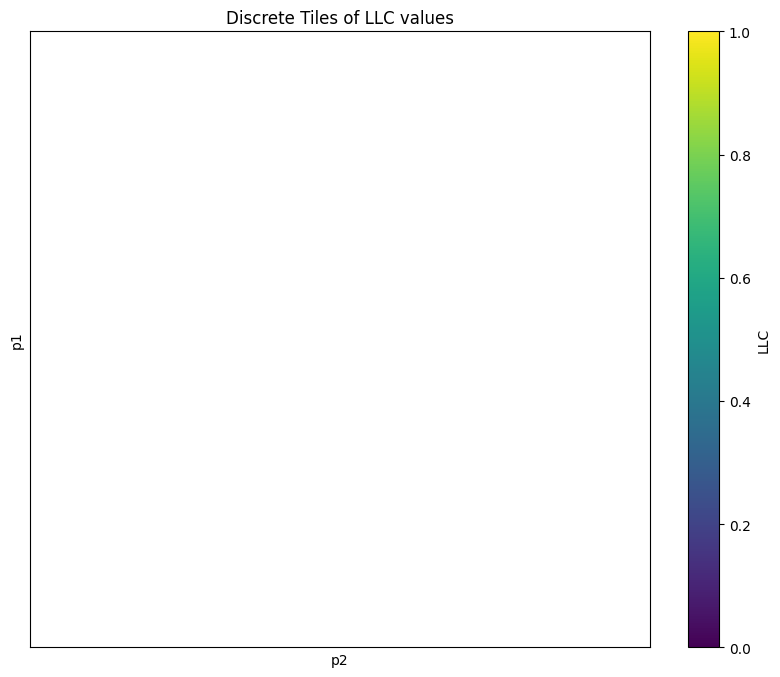

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('llc_results.csv')

pivot_table = df.pivot(index='p1', columns='p2', values='LLC')

plt.figure(figsize=(10, 8))
plt.imshow(pivot_table, cmap='viridis', aspect='auto')
plt.colorbar(label='LLC')
plt.title('Discrete Tiles of LLC values')
plt.xlabel('p2')
plt.ylabel('p1')
plt.xticks(ticks=range(len(pivot_table.columns)), labels=pivot_table.columns)
plt.yticks(ticks=range(len(pivot_table.index)), labels=pivot_table.index)
plt.show()
